# Kijiji Scraper In Action 
#### By: Nicholas Ogawa

This notebook is an example of my KijijiScraper in action. The ultimate endgoal is to geoplot the rental postings and offer rudimentary insights from the scraped dataset. The colors represent the quantile ranking price per square foot of each posting.



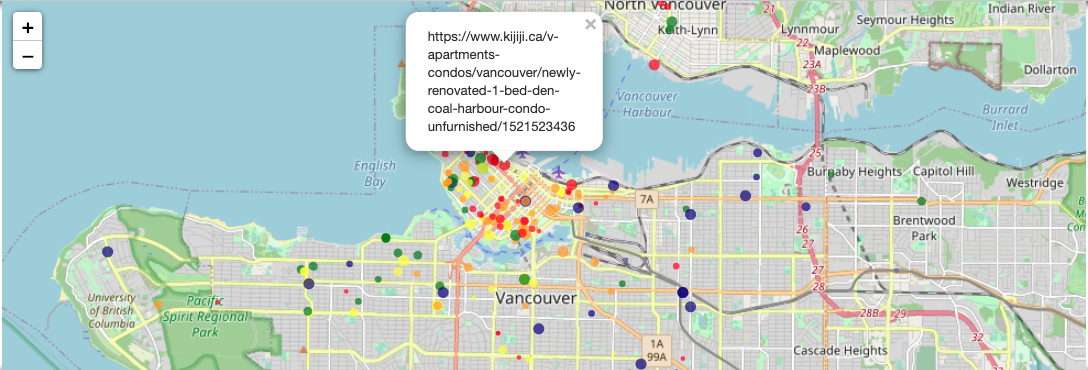

In [1]:
from KijijiScraping import KijijiScraper #Scraper
import mysql.connector #Connecting to SQL 
import pandas as pd #Data Analysis
import matplotlib.pyplot as plt #Simple, but useful plotting
import seaborn as sns 
import regex as re # Text searching for postal codes
import numpy as np # 
import folium #Geoplotting visualization package

In [2]:
action_scraper = KijijiScraper(url = 'https://www.kijiji.ca/b-apartments-condos/vancouver/1+bedroom__1+bedroom+den__bachelor+studio/c37l1700287a27949001',
                           host = "localhost", user = "root", password = 'enter your password', database = 'kijijidb',
                            tablename= 'rental4')

In [3]:
action_scraper.ScrapeInit(1)

In [4]:
conn = mysql.connector.connect(host='localhost',
                                       user='root',
                                       password='enter your password',
                                       database = 'kijijidb')
cursor = conn.cursor()
# Change the values based on what you want to analyze...
# 1 bedrooms, 2 bedrooms etc
cursor.execute("SELECT * FROM rental4")
rows = cursor.fetchall()

df = pd.DataFrame(rows, columns = [ 'id' ,'title', 'dateposted', 'price', 'address'
                                       , 'bathrooms', 'bedrooms', 'sqft', 'furnished', 'outdoor', 'pets',
                                       'utilities', 'type', 'url'])
conn.close()

In [5]:
# Option setting
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width', 200)
pd.set_option("display.max_rows", 100)

/Users/nicoogawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [6]:
df.head(5)

,id,title,dateposted,price,address,bathrooms,bedrooms,sqft,furnished,outdoor,pets,utilities,type,url
0,1194131710,LUXURY FURNISHED ONE BEDROOM SUITE,2020-08-16,1600.0,567 Hornby St Vancouver BC V6C 2E8 Canada,1,1,500.0,Yes,Not,No,Some,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/luxury-furnished-one-bedroom-suite/1194131710
1,1306103279,Modern New Apartments In Yaletown - Fully Furnished.,None,4050.0,Vancouver BC V6B0G1 Canada,1,1,500.0,Yes,Balcony,Yes,All,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/modern-new-apartments-in-yaletown-fully-furnished/1306103279
2,1467689563,$1550 / 1br - Kitsilano/Close to UBC Highbury (Sml Pet ok,2020-09-01,1550.0,3755 W 6th Ave Vancouver BC V6R 1V1 Canada,1,1,600.0,No,Balcony,Yes,Some,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/1550-1br-kitsilano-close-to-ubc-highbury-sml-pet-ok/1467689563
3,1478086929,Aspen&Bow-a boutique move in ready 1 bedroom home available,2020-09-01,1600.0,1150 Memorial Dr NW Calgary AB T2N 3E5 Canada,1,1,590.0,No,Balcony,Yes,Some,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/aspen-bow-a-boutique-move-in-ready-1-bedroom-home-available/1478086929
4,1486203824,"1 Bedroom for rent in Vancouver close to Downtown,SFU,BCIT,CapU",None,899.0,3441 E Georgia St Vancouver BC V5K 2L6 Canada,1,1,300.0,Yes,Yard,No,All,House,https://www.kijiji.ca/v-apartments-condos/vancouver/1-bedroom-for-rent-in-vancouver-close-to-downtown-sfu-bcit-capu/1486203824


In [7]:
df.describe()

,id,price,bathrooms,bedrooms,sqft
count,3.260000e+02,312.000000,326.000000,326.000000,310.000000
mean,1.515320e+09,1694.237179,1.027607,0.975460,731.264516
std,2.244032e+07,564.559153,0.252687,0.154956,1244.323359
min,1.194132e+09,450.000000,1.000000,0.000000,1.000000
25%,1.513233e+09,1400.000000,1.000000,1.000000,500.000000
50%,1.519946e+09,1725.000000,1.000000,1.000000,579.000000
75%,1.521603e+09,1956.250000,1.000000,1.000000,650.000000
max,1.522618e+09,4250.000000,4.000000,1.000000,9999.000000


Notice the maximum and minimums: It is clear there are incorrect data entries on Kijiji for our scraper.

In [8]:
df.isna().sum()

id            0 
title         0 
dateposted    29
price         14
address       0 
bathrooms     0 
bedrooms      0 
sqft          16
furnished     0 
outdoor       0 
pets          0 
utilities     0 
type          0 
url           0 
dtype: int64

### Ellaborating on the Unavailable Data entries:
- `date` will post a `None` if the link was posted over a month from the date of scraping. Since the date is no longer available on Kijiji. 

- `price` can have the option of "Please Contact". I decided to leave this entry as None since Price will most likely be the dependent variable when conducting analysis. 

- `sqft` can be posted optionally. An annoyance but we can work around it.

In [9]:
#Removal of super sized apartments or tiny apartments
df = df[df.sqft < 5000]
df = df[50< df.sqft ]
df.reset_index().head(5)

,index,id,title,dateposted,price,address,bathrooms,bedrooms,sqft,furnished,outdoor,pets,utilities,type,url
0,0,1194131710,LUXURY FURNISHED ONE BEDROOM SUITE,2020-08-16,1600.0,567 Hornby St Vancouver BC V6C 2E8 Canada,1,1,500.0,Yes,Not,No,Some,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/luxury-furnished-one-bedroom-suite/1194131710
1,1,1306103279,Modern New Apartments In Yaletown - Fully Furnished.,None,4050.0,Vancouver BC V6B0G1 Canada,1,1,500.0,Yes,Balcony,Yes,All,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/modern-new-apartments-in-yaletown-fully-furnished/1306103279
2,2,1467689563,$1550 / 1br - Kitsilano/Close to UBC Highbury (Sml Pet ok,2020-09-01,1550.0,3755 W 6th Ave Vancouver BC V6R 1V1 Canada,1,1,600.0,No,Balcony,Yes,Some,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/1550-1br-kitsilano-close-to-ubc-highbury-sml-pet-ok/1467689563
3,3,1478086929,Aspen&Bow-a boutique move in ready 1 bedroom home available,2020-09-01,1600.0,1150 Memorial Dr NW Calgary AB T2N 3E5 Canada,1,1,590.0,No,Balcony,Yes,Some,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/aspen-bow-a-boutique-move-in-ready-1-bedroom-home-available/1478086929
4,4,1486203824,"1 Bedroom for rent in Vancouver close to Downtown,SFU,BCIT,CapU",None,899.0,3441 E Georgia St Vancouver BC V5K 2L6 Canada,1,1,300.0,Yes,Yard,No,All,House,https://www.kijiji.ca/v-apartments-condos/vancouver/1-bedroom-for-rent-in-vancouver-close-to-downtown-sfu-bcit-capu/1486203824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,320,1522460398,Stunning Penthouse with Rooftop Patio for Rent in Gastown,2020-09-06,4250.0,27 Alexander St Vancouver BC V6A 1B2 Canada,1,1,775.0,Yes,Balcony,Yes,All,Condo,https://www.kijiji.ca/v-apartments-condos/vancouver/stunning-penthouse-with-rooftop-patio-for-rent-in-gastown/1522460398
291,321,1522477052,"$2,150/615ft2 - Bright and Beautiful Spacious 1-Bed",2020-09-07,2150.0,521-384 E 1st Ave Vancouver BC V5T 1A7 Canada,1,1,615.0,Yes,Balcony,Limited,No,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/2-150-615ft2-bright-and-beautiful-spacious-1-bed/1522477052
292,323,1522503614,ROOM FOR RENT IN A 3 BDR CONDO. 5 MINS TO JOYCE SKYTRAIN STATION,2020-09-07,720.0,V5R 6H4 Vancouver BC,1,1,680.0,Yes,Yard,No,Some,Condo,https://www.kijiji.ca/v-apartments-condos/vancouver/room-for-rent-in-a-3-bdr-condo-5-mins-to-joyce-skytrain-station/1522503614
293,324,1522568105,Private Bedroom in 2 Bedroom East Vancouver Apartment,2020-09-07,850.0,765 Victoria Dr Vancouver BC V5L 4E5 Canada,1,1,800.0,No,Not,No,Some,Apartment,https://www.kijiji.ca/v-apartments-condos/vancouver/private-bedroom-in-2-bedroom-east-vancouver-apartment/1522568105


### Histograms for Distributions

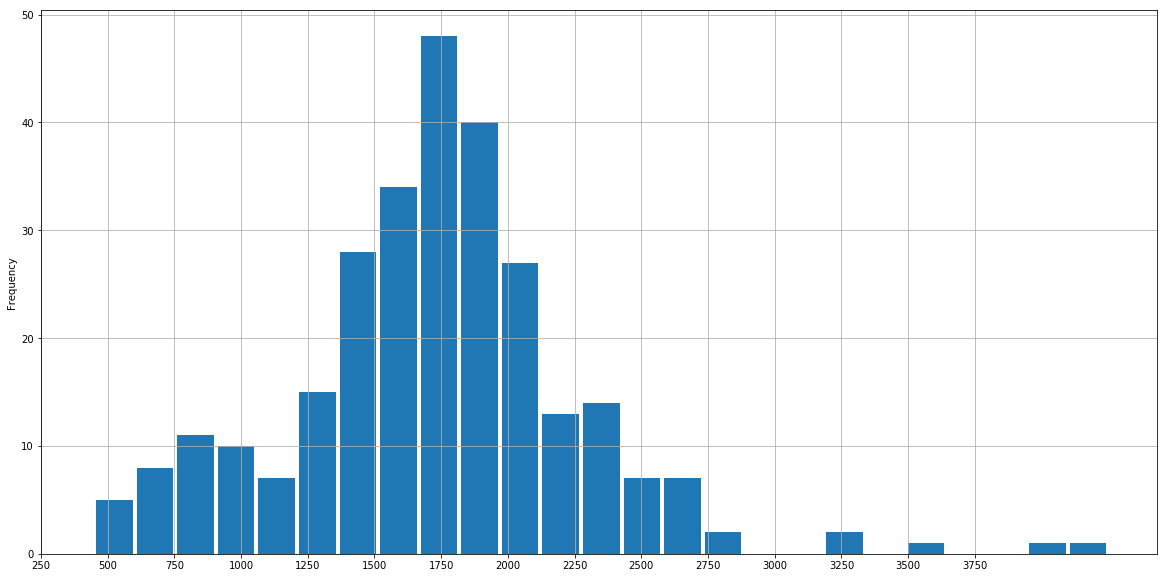

In [10]:
# Price Distribution
plt.figure(figsize=(20,10));
df['price'].plot.hist(grid=True, bins=25, rwidth=0.9)
plt.xticks(range(250, 4000, 250));

In [11]:
df = df.drop(df[df.utilities == '+'].index) 
df = df.drop(df[df.utilities == 'Furnished'].index)

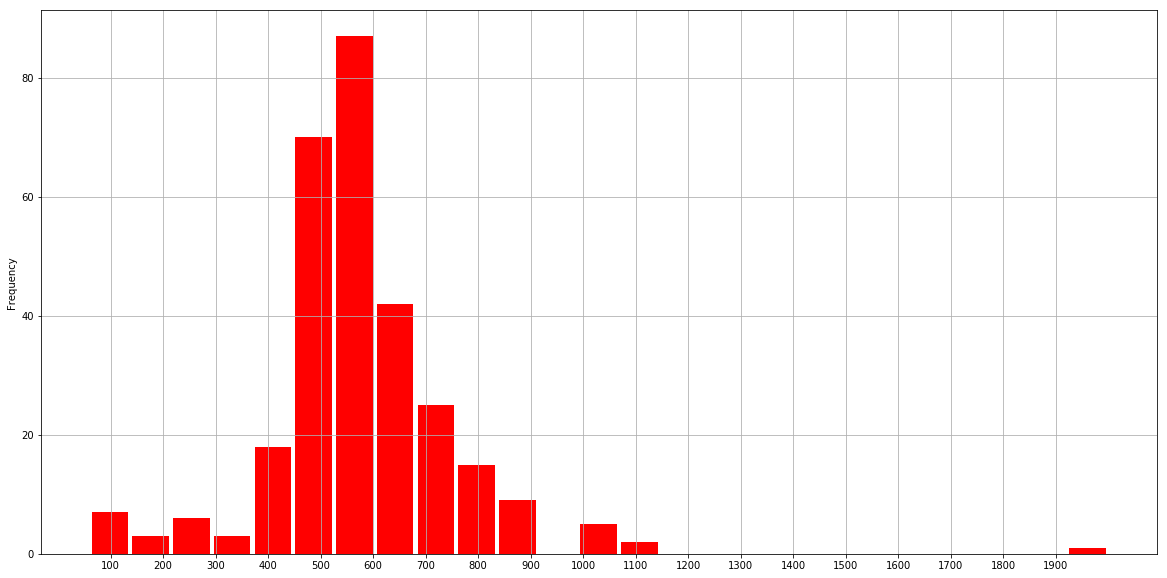

In [12]:
# Square footage distribution
plt.figure(figsize=(20,10));
df['sqft'].plot.hist(grid=True, bins=25, rwidth=0.9, color = 'red');
plt.xticks(range(100, 2000, 100));

In [13]:
print(df['furnished'].unique())
print(df['outdoor'].unique())
print(df['pets'].unique())
print(df['type'].unique())
print(df['utilities'].unique())

['Yes' 'No']
['Not' 'Balcony' 'Yard']
['No' 'Yes' 'Limited']
['Apartment' 'House' 'Condo' 'Townhouse' 'Basement' 'Duplex/Triplex']
['Some' 'All' 'No']


In [14]:
category_list = ['furnished','outdoor', 'pets','type','utilities']

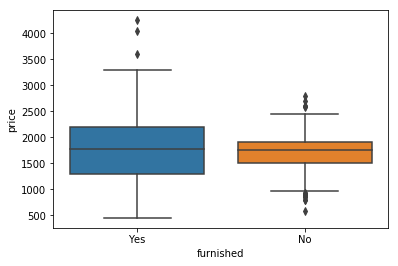

In [15]:
sns.boxplot("furnished","price",data=df);

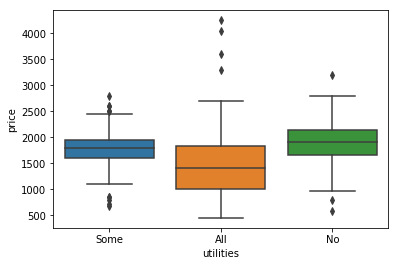

In [16]:
sns.boxplot("utilities","price",data=df);

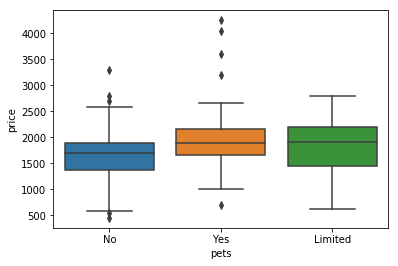

In [17]:
sns.boxplot("pets","price",data=df);

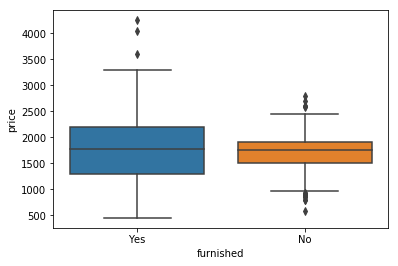

In [18]:
sns.boxplot("furnished","price",data=df);

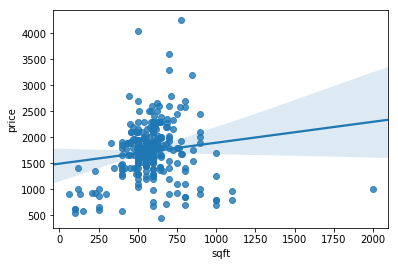

In [19]:
sns.regplot('sqft', 'price', data=df);

It is clear `price` and `squarefoot` don't tell the tale. Lets bring location into the equation

In [20]:
def postalcode(address):
    '''
    Function to obtain the postal code from the addresses on the orginial dataframe
    [V] represents Vancouver homes only. Kijiji has sponsored ads which includes
    areas outside of Vancouver
    '''
    postalcode = re.search("[V][0-9][ABCEGHJKLMNPRSTVWXYZ] ?[0-9][ABCEGHJKLMNPRSTVWXYZ][0-9]", address, re.IGNORECASE)     
    if postalcode: 
        return postalcode.group().replace(' ','').upper()

In [21]:
df['postalcode'] = df['address'].apply(postalcode)

In [22]:
# Now we have an address and postalcode, lets drop dataframes without a postalcode offered
df = df.dropna(axis = 0).reset_index()

### Zoning
- One can also look at zoning layouts to get better insights for prices in specific areas

In [23]:
# Zoning 
def zone(postalcode):
    return postalcode[0:3]

In [24]:
df['zone'] = df['postalcode'].apply(zone)

In [25]:
df['zone'].unique()

array(['V6C', 'V6R', 'V6E', 'V5X', 'V6P', 'V6M', 'V6J', 'V3J', 'V6G',
       'V7L', 'V6A', 'V5R', 'V5N', 'V5T', 'V3K', 'V5S', 'V5J', 'V6B',
       'V6K', 'V5Z', 'V6Z', 'V5V', 'V5W', 'V5K', 'V6H', 'V5L', 'V6T',
       'V3H', 'V6N', 'V5P', 'V5Y', 'V3L', 'V3T', 'V7M', 'V1Y', 'V7A',
       'V5C'], dtype=object)

### Zoning Groupby 

Grouping each zone ,then finding the price, square footage and price per squarefoot in each zone area. 

Unfortunately, Canada does not provide easily accessible zoning geojson maps for greater analysis of each zone. But if you google the V6B, you will obtain the name and its region. 

#### Lets add 2 columns
- Price per squarefoot 
- Squarefeet per bedroom

Worth acknowledging, is the lack of perfect linearity between bedrooms and square feet. Another bedroom added doesn't equate to the same proportion of square footage for each bedroom (Non-linear relationship).

In [27]:
df['P_per_sqft']= df['price']/df['sqft'] 
df['sqft_per_bedroom'] = df['sqft']/df['bedrooms'] 

In [29]:
zoningaveragedf = df.groupby('zone')['price', 'sqft', 'P_per_sqft'].mean()
zonecount = df.groupby('zone').count()[['id']] #Adding a count
zoningaveragedf = zonecount.merge(zoningaveragedf, left_on = zonecount.index, right_on = zoningaveragedf.index )
zoningaveragedf
zoningaveragedf = zoningaveragedf.rename(columns={'id': 'Count', 'key_0': 'zone'})
zoningaveragedf = zoningaveragedf.set_index('zone')
zoningaveragedf.sort_values(by='P_per_sqft', ascending = False)

/Users/nicoogawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Count,price,sqft,P_per_sqft
zone,,,,
V3L,1,1890.000000,328.000000,5.762195
V6B,20,2096.950000,605.600000,4.064506
V6Z,18,2205.277778,575.611111,3.886324
V7M,2,1910.000000,500.000000,3.820000
V6A,13,1900.769231,544.923077,3.819395
V3H,1,1650.000000,440.000000,3.750000
V7L,3,2645.000000,741.333333,3.628272
V6E,20,2030.200000,562.550000,3.616522
V5Z,15,1649.666667,513.600000,3.592538


In [32]:
zoningaveragedf.describe()

,Count,price,sqft,P_per_sqft
count,37.000000,37.000000,37.000000,37.000000
mean,6.405405,1665.351664,608.615104,2.950371
std,6.796484,329.225750,115.860770,0.802118
min,1.000000,1121.666667,328.000000,1.700000
25%,2.000000,1400.000000,550.000000,2.444022
50%,3.000000,1650.000000,590.375000,2.874222
75%,9.000000,1810.000000,637.500000,3.368976
max,28.000000,2645.000000,1000.000000,5.762195


## Using Google Maps Geocode 
Google maps offers APIs that *eventually* cost money, but they give you $500 of free credit. This requires an API setup.

In [33]:
import googlemaps
gmaps = googlemaps.Client(key='Enter Your API Key')

In [34]:
def get_lng(postalcode):
    '''
    Obtaining longitude
    '''
    geocode_result = gmaps.geocode(postalcode)
    try:
        if 'location' in geocode_result[0]['geometry']:
            return geocode_result[0]['geometry']['location']['lng']
        else:
            return geocode_result[0]['geometry']['northeast']['lng']
    except (KeyError, IndexError):
        return np.nan

In [35]:
def get_lat(postalcode):
    '''
    Obtaining latitude
    '''
    geocode_result = gmaps.geocode(postalcode)
    try:
        if 'location' in geocode_result[0]['geometry']:
            return geocode_result[0]['geometry']['location']['lat']
        else:
            return geocode_result[0]['geometry']['northeast']['lat']
    except (KeyError, IndexError):
        return np.nan

In [36]:
df['lat'] = df['postalcode'].apply(get_lat)
df['lng'] = df['postalcode'].apply(get_lng)

In [37]:
df = df.dropna(axis = 0).reset_index()

In [41]:
# These two columns are added for plotting purposes. Color schemes based on the Price per square foot and 
# circle size based on square foot per bedroom

df['color']=df['P_per_sqft'].apply(lambda P_per_sqft:"Red" if P_per_sqft >= df['P_per_sqft'].quantile(0.8) else 
                                   "Orange" if P_per_sqft >= df['P_per_sqft'].quantile(0.6) and P_per_sqft < df['P_per_sqft'].quantile(0.8) else
                                   "yellow" if P_per_sqft >= df['P_per_sqft'].quantile(0.4) and P_per_sqft < df['P_per_sqft'].quantile(0.6) else
                                   "green" if P_per_sqft >= df['P_per_sqft'].quantile(0.2) and P_per_sqft < df['P_per_sqft'].quantile(0.4) else
                                   "darkblue")


df['size']=df['sqft_per_bedroom'].apply(lambda sqft_per_bedroom: 5 if sqft_per_bedroom >= df['sqft_per_bedroom'].quantile(0.75) else 
                                   4 if sqft_per_bedroom >= df['sqft_per_bedroom'].quantile(0.5) and sqft_per_bedroom < df['sqft_per_bedroom'].quantile(0.75) else
                                   3 if sqft_per_bedroom >= df['sqft_per_bedroom'].quantile(0.25) and sqft_per_bedroom < df['sqft_per_bedroom'].quantile(0.5) else
                                   2)

In [39]:
m = folium.Map(location=[49.2600239, -123.1171651], zoom_start=11)

for lat, long, color, size, url in zip(df['lat'],df['lng'], df['color'], df['size'], df['url']):
    folium.CircleMarker([lat, long],
                            color='b',
                            popup = url,
                            radius=size,
                            fill_color = color,
                            fill=True,
                            fill_opacity=0.7).add_to(m)

In [40]:
m

### Interpretation

- The size of the circles represent the squarefootage per bedroom. 
- The color of the circles represent the price per suare foot:

- RED: Top 20th Percentile (Most expensive)
- ORANGE: 20th-40th Percentile 
- YELLOW: 40th- 60th Percentile
- GREEN: 60th-80th Percentile
- BLUE: 80-100th Percentile (Cheapest)


### Other comments

Although there is much more one can do with this dataset, a quantile-based geoplot with rental prices can help individuals with finding a place. Obviously, there could be some prediction modelling here, but I believe that we have limited features in comparison to other datasets. For example, the Boston housing dataset offers valuable information like the year the house was built, the house's frame, and the house's reselling frequency etc. 

Therefore, I think that location, price and square footage are robust "naive" strategies to search for an undervalued home since the visual interpertibility is understandable to anyone. Although, I am curious on the results of applying a K-means cluserting algorithm to the data using spatial distances and other features for rental price prediction.

I wanted to make an interpretable, visual display of the Vancouver rental market which could be used in any other city for young professionals and students. The notebook shows the potential of using Kijiji's rental data for making better-informed decisions. 